<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/gradient_boosting_machine_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting Machine in R (GBM)

Zia Ahmed, University at Buffalo

Gradient Boosting Machine (GBM) is a powerful and popular supervised learning algorithm used for both regression and classification tasks. It belongs to the family of ensemble methods, which combine multiple weak learners to form a stronger model. The idea behind gradient boosting is to iteratively improve a model's predictions by fitting a new model to the residuals or errors of the previous models.

Whereas random forests build an ensemble of deep independent trees, GBMs build an ensemble of shallow and weak successive trees with each tree learning and improving on the previous. When combined, these many weak successive trees produce a powerful "committee" that are often hard to beat with other algorithms.

The main idea of boosting is to add new models to the ensemble sequentially. At each particular iteration, a new weak, base-learner model is trained with respect to the error of the whole ensemble learnt so far.

Here's how GBM works:

1.  Initially, a simple model is fitted to the data. This can be any model such as a decision tree, linear regression, or logistic regression.

2.  The model's predictions are compared with the actual values of the target variable, and the errors or residuals are calculated.

3.  A new model is then fitted to these residuals, with the aim of reducing the errors made by the first model. The new model is usually a decision tree, but can also be another type of model.

4.  The predictions of this new model are added to the predictions of the previous model, and the errors are recalculated.

5.  Steps 3 and 4 are repeated iteratively, with each new model attempting to reduce the errors of the previous model. The final predictions are the sum of the predictions of all the models.

6.  To avoid overfitting, the model can be regularized by adding constraints on the size or complexity of the trees, or by using early stopping.

Gradient boosting has several advantages over other methods, such as its ability to handle different types of data (e.g. numerical, categorical), its robustness to outliers and noise, and its high accuracy on many problems. However, it can also be computationally expensive and sensitive to hyperparameters, such as the learning rate, the number of trees, and the depth of the trees.

#### Diffrence between random forest and GBM

Random Forest (RF) and Gradient Boosting Machine (GBM) are both popular ensemble methods used for supervised learning tasks. While they share some similarities, there are several key differences between the two algorithms:

1.  Sampling approach: RF builds multiple decision trees on randomly sampled subsets of the data with replacement, while GBM builds trees sequentially on the residuals or errors of the previous trees.

2.  Learning process: RF trees are built independently, while GBM trees are built in a sequential manner, with each new tree attempting to improve upon the errors of the previous trees.

3.  Bias-variance tradeoff: RF tends to have a lower variance and higher bias, while GBM tends to have a lower bias and higher variance.

4.  Model interpretability: RF is generally more interpretable, as the feature importances can be easily calculated based on the frequency of their use in the trees. GBM, on the other hand, can be more challenging to interpret, as the importance of each feature depends on the interaction with other features and the specific stage of the boosting process.

5.  Performance: Both RF and GBM can perform well on a wide range of problems, but their performance may depend on the specific characteristics of the data and the problem at hand.

In general, RF may be a good choice for problems where model interpretability is important, or where there are many noisy or irrelevant features. GBM may be a good choice for problems where high accuracy is desired, and where the data has complex interactions between features. However, the choice between RF and GBM ultimately depends on the specific characteristics of the problem and the goals of the analysis.

### Install rpy2

In [1]:

!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314928 sha256=8ff4ee2cf3820a822b8a6bce6dd5818a74a65005dd376d3bced51c24002468eb
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Packages

In [3]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'caret', 'Metrics', 'ggpmisc', 'vip', 'patchwork','randomForest','ranger', 'lightgbm', 'fastDummies', 'bonsai', 'gbm')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')


In [ ]:
%%R
# h20
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

### Load R package

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(gbm)
library(ggpmisc)
library(vip)



### Data

In this exercise we will use following data se and use DEM, MAP, MAT, NAVI, NLCD, and FRG to fit a GBM regression model.

[gp_soil_data.csv](https://www.dropbox.com/s/9ikm5yct36oflei/gp_soil_data.csv?dl=0)



In [ ]:
%%R
# load data from github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

### Data Preprocessing

#### Convert to factor

In [6]:
%%R
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Split Data

We use **rsample** package, install with **tidymodels**, to split data into training (70%) and test data (30%) set with Stratified Random Sampling. initial_split() creates a single binary split of the data into a training set and testing set.

In [7]:
%%R
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()

##### Feature Scaling

In [8]:
%%R
train[-c(1, 11,12)] = scale(train[-c(1,11,12)])
test[-c(1, 11,12)] = scale(test[-c(1,11,12)])

## Gradient Boosting Machine (GBM) with gbm package

The gbm R package is an implementation of extensions to Freund and Schapire's AdaBoost algorithm and Friedman's gradient boosting machine. This is the original R implementation of GBM.

We will fit a tree-based GBM model with a foillowing parameters using gbm() functio:  

* distribution: "gaussian",specifying  data distribution
* n.trees"  5000,  the total number of trees to fit,default 100
* interaction.depth: ,maximum depth of each tree, A value of 1 implies an additive model, a value of 2 implies a model with up to 2-way interactions, etc. Default is 1,
* shrinkage: 0.001, shrinkage parameter applied to each tree in the expansion. Also known as the learning rate or step-size reduction; 0.001 to 0.1 usually work,
but a smaller learning rate typically requires more trees. Default is 0.1.
* bag.fraction:  0.7,the fraction of the training set observations randomly selected to propose the next tree in the expansion. This introduces randomnesses into the model fit. If bag.fraction < 1 then running the same model twice will result in similar but different fits. gbm uses the R random number generator so set.seed can ensure that the model can be reconstructed. Preferably, the user can save the returned gbm.object using save. Default is 0.5
* n.minobsinnode: 10,  Integer specifying the minimum number of observations in the terminal nodes of the trees. Note that this is the actual number of observations, not the total weight.
* cv.folds: 5, cross-validation folds
* n.cores = NULL, will use all cores by default
* verbose = F Logical indicating whether or not to print out progress and performance indicators (TRUE)  

In [9]:
%%R
set.seed(123)
gbm.fit <- gbm(SOC ~ ., data = train,  distribution = "gaussian", n.trees = 5000, shrinkage = 0.001,
                 interaction.depth = 1, bag.fraction = 0.7,
                 n.minobsinnode = 10, cv.folds = 5, keep.data = TRUE,
                 verbose = FALSE, n.cores = 1)

CV: 1 
CV: 2 
CV: 3 
CV: 4 
CV: 5 


In [11]:
%%R
gbm.fit

gbm(formula = SOC ~ ., distribution = "gaussian", data = train, 
    n.trees = 5000, interaction.depth = 1, n.minobsinnode = 10, 
    shrinkage = 0.001, bag.fraction = 0.7, cv.folds = 5, keep.data = TRUE, 
    verbose = FALSE, n.cores = 1)
A gradient boosted model with gaussian loss function.
5000 iterations were performed.
The best cross-validation iteration was 4999.
There were 11 predictors of which 11 had non-zero influence.


In [12]:
%%R
# get MSE and compute RMSE
sqrt(min(gbm.fit$cv.error))

[1] 4.048704


#### Plot loss function as a result of n trees added to the ensemble

Estimates the optimal number of boosting iterations for a gbm object and optionally plots various performance measures

[1] 4999


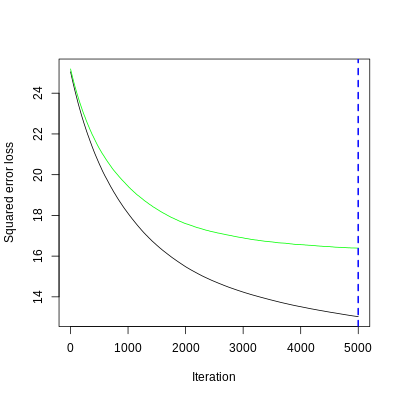

In [13]:
%%R -w 400 -h 400 -u px
gbm.perf(gbm.fit, method = "cv")

In [14]:
%%R
test$SOC.pred.gbm = predict(gbm.fit, newdata = test)

In [15]:
%%R
# RMSE
Metrics::rmse(test$SOC, test$SOC.pred.gbm)

[1] 3.551811


`geom_smooth()` using formula = 'y ~ x'


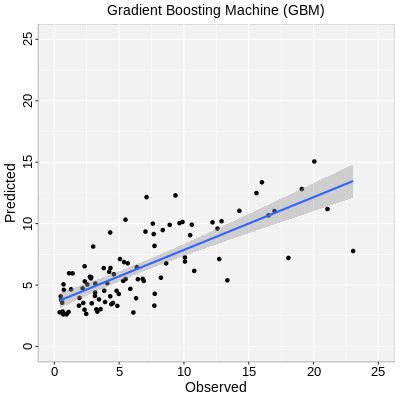

In [16]:
%%R -w 400 -h 400 -u px
ggplot(test, aes(SOC,SOC.pred.gbm)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Gradient Boosting Machine (GBM)") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## Variable importance

Applying the **summary()** function to a gbm output produces both a Variable Importance Table and a Plot of the model.

"method" in this function used to compute  in two ways:

method = relative.influence: At each split in each tree, gbm computes the improvement in the split-criterion (MSE for regression). gbm then averages the improvement made by each variable across all the trees that the variable is used. The variables with the largest average decrease in MSE are considered most important.

method = permutation.test.gbm: For each tree, the OOB sample is passed down the tree and the prediction accuracy is recorded. Then the values for each variable (one at a time) are randomly permuted and the accuracy is again computed. The decrease in accuracy as a result of this randomly "shaking up" of variable values is averaged over all the trees for each variable. The variables with the largest average decrease in accuracy are considered most important.

              var     rel.inf
NDVI         NDVI 52.09603067
Slope       Slope 17.14561551
KFactor   KFactor  8.88833917
MAP           MAP  8.26695710
MAT           MAT  6.32569710
TPI           TPI  4.43652466
DEM           DEM  1.36584137
SiltClay SiltClay  1.21849802
Aspect     Aspect  0.13497620
NLCD         NLCD  0.06398776
FRG           FRG  0.05753245


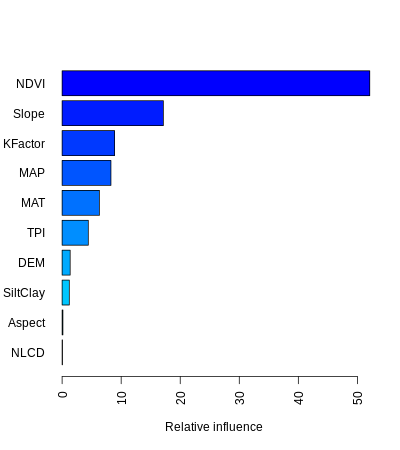

In [18]:
%%R -w 400 -h 450 -u px
summary(
  gbm.fit,
  cBars = 10,
  method = relative.influence, # also can use permutation.test.gbm
  las = 2
  )

An alternative approach is to use the vip package, which provides ggplot2 plots. vip also provides an additional measure of variable importance based on partial dependence measures and is a common variable importance plotting framework for many machine learning models

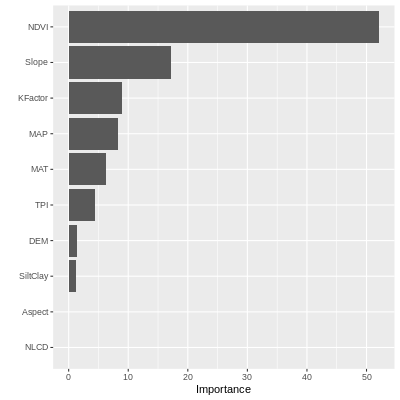

In [ ]:
%%R -w 400 -h 400 -u px
vip(gbm.fit)

## GBM with h20

h20 includes an implementation of gradient boosting machine (GBM) that can be used for both regression and classification problems. H2O's GBM sequentially builds regression trees on all the features of the dataset in a fully distributed way - each tree is built in parallel.

### Load h20

In [ ]:
%%R
.libPaths('drive/My Drive/R')
library(h2o)
h2o.init(nthreads = -1, max_mem_size = "10g", enable_assertions = FALSE)
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

### Load data

In [21]:
%%R
# loda data from you github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)
# convrt factor
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()
# Scale data
train[-c(1, 11,12)] = scale(train[-c(1,11,12)])
test[-c(1, 11,12)] = scale(test[-c(1,11,12)])

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Import data to h2o cluster

In [22]:
%%R
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [23]:
%%R
CV.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

#### Define response and predictors

In [24]:
%%R
y <- "SOC"
x <- setdiff(names(h_df), y)

### Fit GBM model

First we will use h2o.gbm() function to build gradient boosted regression trees with the following predefined hyper-parameters:

* ntrees: 5000,  number of trees. Defaults to 50
* max_depth: 5, maximum tree depth (0 for unlimited). Defaults to 5
* min_rows: 8, fewest allowed (weighted) observations in a leaf. Defaults to 10.
* sample_rate: 0.7, row sample rate per tree (from 0.0 to 1.0) Defaults to 1.
* learn_rate: 0.05, learning rate (from 0.0 to 1.0) Defaults to 0.1.
* col_sample_rate: 0.6, column sample rate (from 0.0 to 1.0) Defaults to 1.
* col_sample_rate_per_tree: 0.5, column sample rate per tree (from 0.0 to 1.0) Defaults to 1.                                    
* stopping_rounds: 2, stop fitting new trees when the 2-tree,  average is within 0.001 (default) of  the prior two 2-tree averages.
* stopping_metric: "RMSE", metric to use for early stopping
* nfolds: 10,  nmber of folds for K-fold cross-validation (0 to disable or >= 2). Defaults to 0.
* keep_cross_validation_models: TRUE, logical. Whether to keep the cross-validation models. Defaults to TRUE.
* seed: 1000000, et the random seed so that this can be reproduced.

In [25]:
%%R
gbm_h2o <- h2o.gbm(
  training_frame = h_train,
  # validation_frame = valid,
  x=x,
  y=y,
  model_id = "GBM_MODEL_IDs",
  ntrees = 5000,
  max_depth =5,
  min_rows = 8,
  sample_rate = 0.7,
  learn_rate = 0.05,
  col_sample_rate = 0.6,
  col_sample_rate_per_tree = 0.5,
  stopping_rounds = 2,
  stopping_metric = "RMSE",
  nfolds = 10,
  keep_cross_validation_models = TRUE,
  seed = 1000000)


In [26]:
%%R
summary(gbm_h2o)

Model Details:

H2ORegressionModel: gbm
Model Key:  GBM_MODEL_IDs 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              27                       27                6798         5
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    5.00000         12         20    15.44444

H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  11.46304
RMSE:  3.385711
MAE:  2.472293
RMSLE:  0.4735253
Mean Residual Deviance :  11.46304



H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  16.60818
RMSE:  4.075314
MAE:  2.967318
RMSLE:  0.5453423
Mean Residual Deviance :  16.60818


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.996883 0.459726   3.582629   3.295636   2.700663
mean_residual_deviance 16.886757 6.00431

In [27]:
%%R
# training performance
h2o.performance(gbm_h2o, h_train)
# CV-performance
h2o.performance(gbm_h2o, xval=TRUE)
# test performance
h2o.performance(gbm_h2o, h_test)

H2ORegressionMetrics: gbm

MSE:  13.28167
RMSE:  3.644403
MAE:  2.712598
RMSLE:  0.545531
Mean Residual Deviance :  13.28167



### Prediction

In [28]:
%%R
pred.gbm_h2o <- as.data.frame(h2o.predict(object = gbm_h2o, newdata = h_test))
test.xy$SOC.gbm_h2o<-pred.gbm_h2o$predict

#### 1:1 Plots of Predicted vs Observed Values

`geom_smooth()` using formula = 'y ~ x'


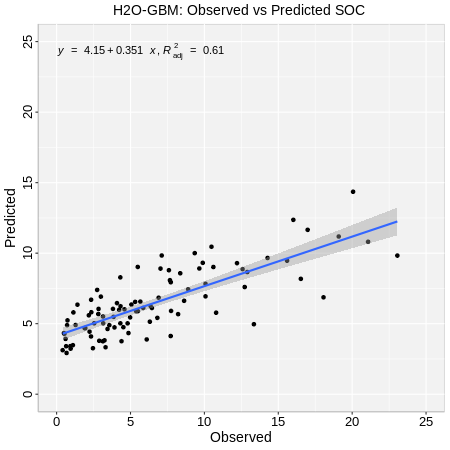

In [29]:
%%R -w 450 -h 450 -u px
formula<-y~x

ggplot(test.xy, aes(SOC,SOC.gbm_h2o)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O-GBM: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Fit GBM model with Grid Serach

#### Define GBM Hyper-parameters and Serch Criteria

In [30]:
%%R
# GBM Hyper-parameters
GBM_hyper_params = list( ntrees = c(100,500, 1000, 5000),
                     max_depth = c(2,5,8),
                     min_rows = c(8,10, 12),
                     learn_rate = c(0.001,0.05,0.06),
                     sample_rate = c(0.4,0.5,0.6, 0.7),
                     col_sample_rate = c(0.4,0.5,0.6),
                     col_sample_rate_per_tree = c(0.4,0.5,0.6))
# search_criteria
search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 40,
                        max_runtime_secs = 300,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)

#### GBM Grid Search

In [31]:
%%R
GBM_grid <- h2o.grid(
                  algorithm="gbm",
                  grid_id = "GBM_grid_IDs",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = GBM_hyper_params,
                  search_criteria = search_criteria,
                  seed = 42)


#### Number of GBM  model trained

In [32]:
%%R
# number GBM
length(GBM_grid@model_ids)

[1] 15


#### The best GBM model

In [34]:
%%R
# Get  Model ID
GBM_get_grid <- h2o.getGrid("GBM_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)

In [35]:
%%R
# Get the best GBM model
best_GBM <- h2o.getModel(GBM_get_grid@model_ids[[1]])
best_GBM

Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_grid_IDs_model_9 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            5000                     5000              527838         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.59920


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  11.36456
RMSE:  3.371136
MAE:  2.42146
RMSLE:  0.4536358
Mean Residual Deviance :  11.36456



H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  15.94491
RMSE:  3.993108
MAE:  2.871634
RMSLE:  0.5194097
Mean Residual Deviance :  15.94491


Cross-Validation Metrics Summary: 
                            mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                     2.869508 0.447764   2.433311   3.158152   3.504614
mean_residual_deviance 16.008745 4.

In [36]:
%%R
# training performance
h2o.performance(best_GBM, h_train)
# CV-performance
h2o.performance(best_GBM, xval=TRUE)
# test performance
h2o.performance(best_GBM, h_test)

H2ORegressionMetrics: gbm

MSE:  11.48568
RMSE:  3.389053
MAE:  2.482061
RMSLE:  0.498921
Mean Residual Deviance :  11.48568



### Prediction

In [37]:
%%R
test.pred.best_gbm<-as.data.frame(h2o.predict(object = best_GBM, newdata = h_test))
test.xy$best_GBM_SOC<-test.pred.best_gbm$predict

#### 1:1 Plot of Predicted vs Observed values

`geom_smooth()` using formula = 'y ~ x'


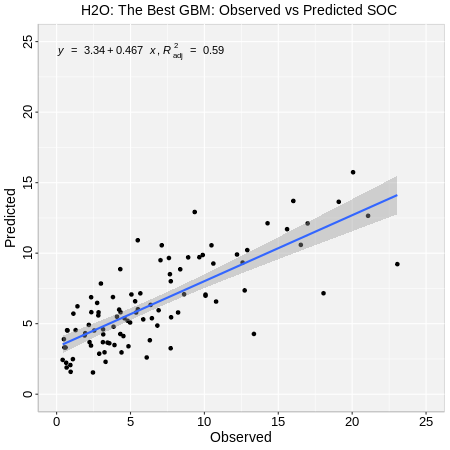

In [38]:
%%R -w 450 -h 450 -u px
formula<-y~x

ggplot(test.xy, aes(SOC,best_GBM_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O: The Best GBM: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

#### Model Explainability

Model explainability refers to the ability to understand and interpret the decisions made by a machine learning model. In other words, it is the ability to explain how a model arrives at its predictions or classifications.

Explainability is particularly important in applications where decisions made by the model have significant real-world consequences, such as in healthcare, finance, and legal fields. It is also important for regulatory compliance, where models must be auditable and transparent.

The h2o.explain() function generates a list of explanations -- individual units of explanation such as a Partial Dependence plot or a Variable Importance plot. Most of the explanations are visual -- these plots can also be created by individual utility functions outside the h2o.explain() function.

##### Retrieve the variable importance.

In [39]:
%%R
h2o.varimp(best_GBM)

Variable Importances: 
   variable relative_importance scaled_importance percentage
1      NDVI       568258.125000          1.000000   0.250853
2       MAP       385554.656250          0.678485   0.170200
3     Slope       271608.906250          0.477967   0.119899
4   KFactor       212565.281250          0.374065   0.093835
5       DEM       198718.953125          0.349698   0.087723
6       MAT       194708.312500          0.342641   0.085952
7      NLCD       126886.890625          0.223291   0.056013
8  SiltClay       112719.523438          0.198360   0.049759
9       TPI       102040.250000          0.179567   0.045045
10   Aspect        53753.714844          0.094594   0.023729
11      FRG        38491.996094          0.067737   0.016992


##### Variable Importance Plot

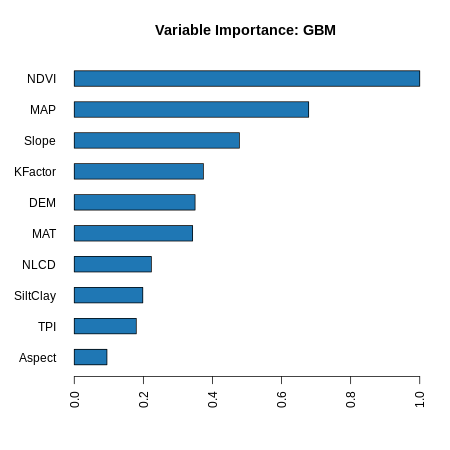

In [40]:
%%R -w 450 -h 450 -u px
h2o.varimp_plot(best_GBM)

#### SHAP Local Explanation

SHAP (SHapley Additive exPlanations) values are a method for explaining the output of any machine learning model. SHAP values provide a way to attribute the prediction of an individual feature to its contribution to the final prediction, taking into account the interaction with other features in the model.

SHAP values are based on the Shapley value from cooperative game theory, which attributes a value to each player in a game based on their contribution to the game's outcome. In the context of machine learning, the "players" are the input features of the model, and the "game" is the prediction made by the model.

The SHAP value for a particular feature is calculated by comparing the model's prediction for a specific data point with and without that feature's value included. This comparison is done for all possible subsets of features, and the contributions of each feature are averaged using the Shapley value formula.

The resulting SHAP values represent the contribution of each feature to the final prediction, with positive values indicating a positive impact on the prediction and negative values indicating a negative impact.

SHAP values can be used to provide insights into how a model is making its predictions and to identify which features are most important for a particular prediction. They can also be used to identify bias in a model and to ensure that the model is making predictions fairly and transparently.

H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

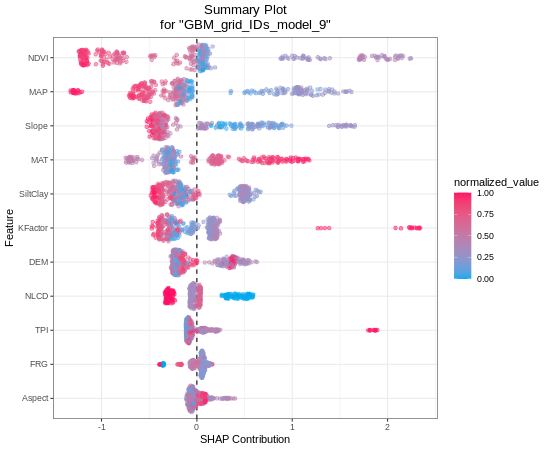

In [41]:
%%R -w 550 -h 450 -u px
h2o.shap_summary_plot(best_GBM, h_train)

#### Partial Dependence (PD) Plots

A partial dependence plot (PDP) is a graphical tool for understanding the relationship between a particular input feature and the output of a machine learning model.

A PDP shows the marginal effect of a single feature on the predicted outcome while holding all other features at a fixed value or their average value. The PDP can help to visualize the shape and direction of the relationship between the feature and the output, and can also help to identify any non-linearities or interactions between the feature and other features in the model.

To create a PDP, the value of the feature of interest is varied over its range, and the model's predicted output is recorded for each value. The resulting data is then plotted on a graph, with the feature's value on the x-axis and the predicted output on the y-axis.

PDPs can be used to gain insights into how a model is making its predictions and to identify which features are most important for the model's output. They can also be used to identify potential biases in the model or to detect interactions between features that may be difficult to detect using other methods.

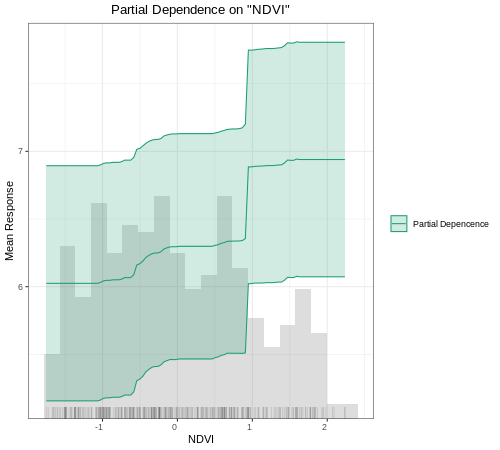

In [ ]:
%%R -w 500 -h 450 -u px
h2o.pd_multi_plot(best_GBM, h_train, "NDVI")

##### Residual Analysis

Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable

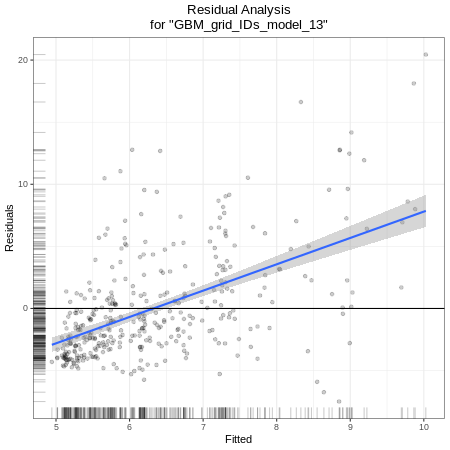

In [ ]:
%%R -w 450 -h 450 -u px
h2o.residual_analysis_plot(best_GBM, h_train)

### Further Reading

### Further Reading

1.  [Gradient Boosting Machines](https://uc-r.github.io/gbm_regression)
2.  Simplest getting started R script [\[Github\]](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.R)
3.  [GBM Booklet](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GBMBooklet.pdf)

### YouTube Video

1.  GBM Regression Main Ideas

{{< video https://www.youtube.com/watch?v=3CC4N4z3GJc >}}

Source: [StatQuest with Josh Starme](https://www.youtube.com/@statquest)

-   Quick GBM using H2O Flow (Lending Club Dataset) [\[Youtube\]](https://www.youtube.com/watch?v=1R9iBBCxhE8)

-   GBM and other algos in R (Citi Bike Dataset) [\[Youtube\]](https://www.youtube.com/watch?v=_ig6ZmBfhH8/) [\[Github\]](https://github.com/h2oai/h2o-3/blob/master/h2o-r/demos/rdemo.citi.bike.small.R/)

-   Prof. Trevor Hastie - Gradient Boosting Machine Learning [\[Youtube\]](https://www.youtube.com/watch?v=wPqtzj5VZus/)